In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Binary classification: 0 vs 1 (Setosa vs Versicolor)
X = X[y != 2]
y = y[y != 2]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_binary = X_scaled[:, :]  # Use only 2 features for quantum

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_binary, y, test_size=0.2, random_state=42)

# For PyTorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train classic model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
acc_classical = accuracy_score(y_test, y_pred)

print(f"Classical Logistic Regression Accuracy: {acc_classical:.4f}")


Classical Logistic Regression Accuracy: 1.0000


In [12]:
import pennylane as qml
import torch.nn as nn

# Quantum circuit
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def quantum_circuit(x, weights):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    return qml.expval(qml.PauliZ(0))

# Model
class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Explicitly set dtype to float32
        self.q_weights = nn.Parameter(torch.rand(2, dtype=torch.float32) * np.pi)

    def forward(self, x):
        # Ensure output is converted to float32
        return torch.stack([quantum_circuit(xi, self.q_weights) for xi in x]).float()


In [13]:
model = QuantumClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    # Ensure consistent dtype by calling .float() on outputs
    outputs = torch.sigmoid(model(X_train_torch)).view(-1, 1).float()
    loss = loss_fn(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 5 | Loss: 0.6958
Epoch 10 | Loss: 0.6949
Epoch 15 | Loss: 0.6956
Epoch 20 | Loss: 0.6932
Epoch 25 | Loss: 0.6938
Epoch 30 | Loss: 0.6936


In [15]:
# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_probs = torch.sigmoid(model(X_test_torch)).view(-1, 1)
    y_pred_quantum = (y_pred_probs > 0.5).float().numpy().flatten()

acc_quantum = accuracy_score(y_test, y_pred_quantum)
print(f"\nQuantum Model Accuracy: {acc_quantum:.4f}")
print(f"Classical Model Accuracy: {acc_classical:.4f}")

print("\nFinal quantum weights:")
print(model.q_weights.data)


Quantum Model Accuracy: 0.3000
Classical Model Accuracy: 1.0000

Final quantum weights:
tensor([1.5191, 0.8266])


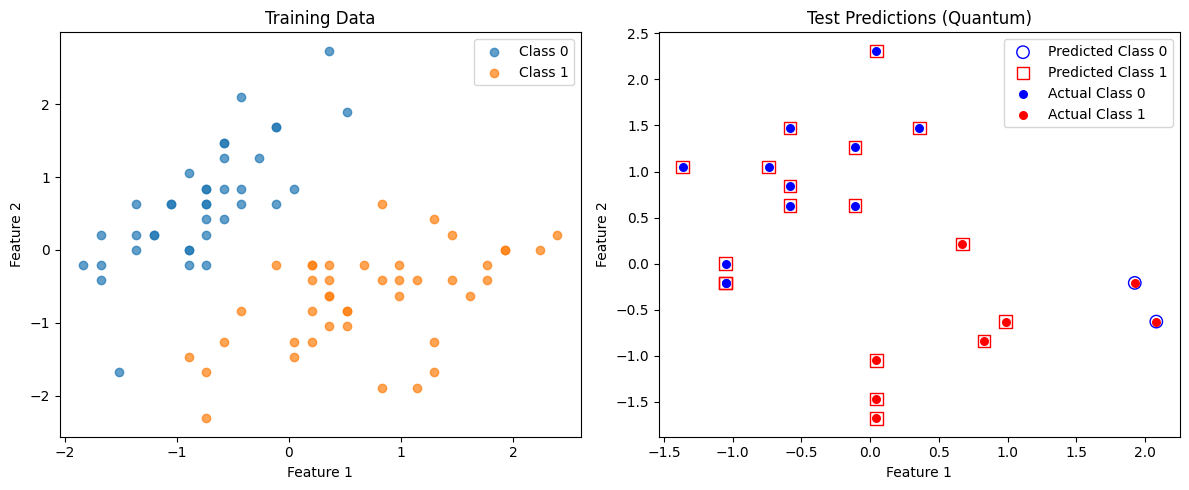

In [16]:
# Visualize decision boundary (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot 1: Training data points
plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Class 0', alpha=0.7)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Class 1', alpha=0.7)
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot 2: Testing data with predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test[y_pred_quantum == 0, 0], X_test[y_pred_quantum == 0, 1], marker='o', 
           edgecolors='blue', facecolors='none', s=80, label='Predicted Class 0')
plt.scatter(X_test[y_pred_quantum == 1, 0], X_test[y_pred_quantum == 1, 1], marker='s', 
           edgecolors='red', facecolors='none', s=80, label='Predicted Class 1')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='blue', s=30, label='Actual Class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='red', s=30, label='Actual Class 1')
plt.title('Test Predictions (Quantum)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()